In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
import calendar

In [ ]:
# --- Load dataset ---
df = pd.read_csv('Tony_data/merged_data.csv')
df.head()

,state,month,population,median_income,initial_claims,Unemployment Rate,lfp_rate
0,Alabama,1987/1/1,4015.264,47750,71032,9.2,61.6
1,Alabama,1987/2/1,4015.264,47750,28758,9.0,61.6
2,Alabama,1987/3/1,4015.264,47750,29053,8.8,61.5
3,Alabama,1987/4/1,4015.264,47750,24599,8.5,61.5
4,Alabama,1987/5/1,4015.264,47750,28278,8.3,61.5


In [ ]:
# --- Utility: Convert time series to supervised format ---
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = DataFrame(data)
    cols = [df.shift(i) for i in range(n_in, 0, -1)] + [df.shift(-i) for i in range(n_out)]
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# --- Parameters ---
states = ["Wyoming", "Louisiana", "Arkansas", "North Dakota"]
n_lags = 12
n_out = 1

# Store metrics
metrics = {"state": [], "rmse": [], "r2": []}
predictions_by_state = {}

# --- Load dataset ---
df = pd.read_csv('Tony_data/merged_data.csv', parse_dates=["month"])
df = df.sort_values(["state", "month"])

# --- Setup Plot ---
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=False)
axs = axs.flatten()

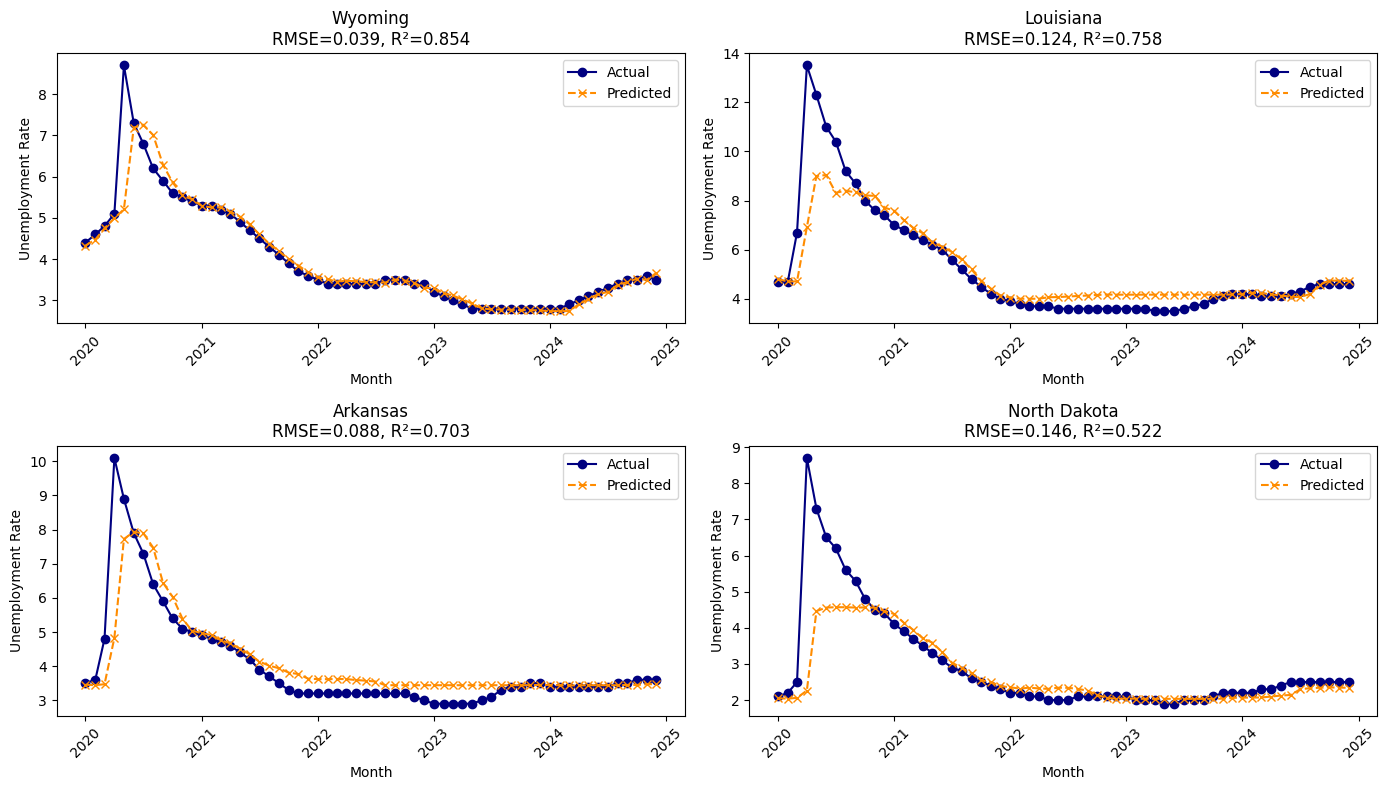

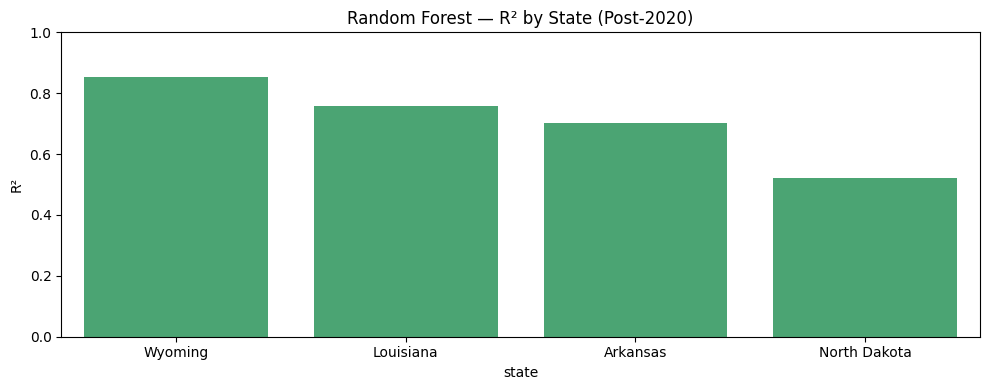

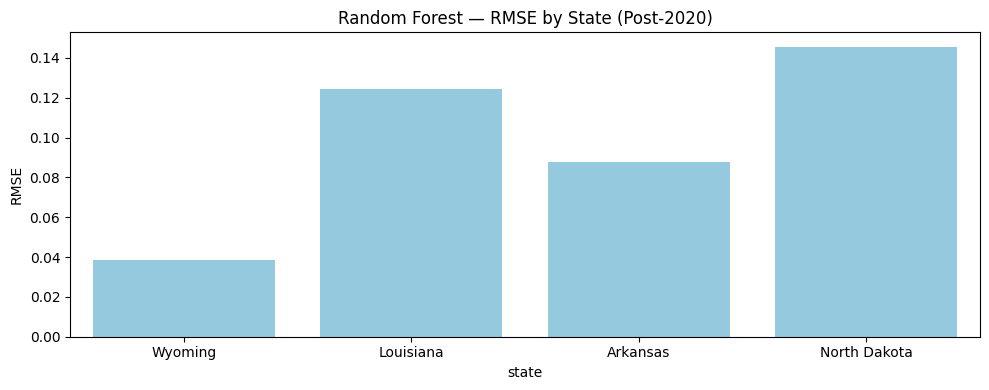

In [ ]:

# --- Loop through each state ---
for i, state in enumerate(states):
    df_state = df[df['state'] == state].copy()
    series = df_state[["month", "Unemployment Rate"]].set_index("month")
    series = series.asfreq('MS')

    # Pre/post 2020 split
    data_pre2020 = series[series.index < "2020-01-01"]
    data_post2020 = series[series.index >= "2020-01-01"]

    # Train on pre-2020
    sup_pre = series_to_supervised(data_pre2020.values, n_in=n_lags, n_out=n_out)
    sup_pre.index = data_pre2020.index[n_lags:]
    trainX = sup_pre.iloc[:, :-1].values
    trainy = sup_pre.iloc[:, -1].values

    model = RandomForestRegressor(n_estimators=1000, random_state=42)
    model.fit(trainX, trainy)

    # Predict post-2020
    combined = pd.concat([data_pre2020, data_post2020])
    sup_all = series_to_supervised(combined.values, n_in=n_lags, n_out=n_out)
    sup_all.index = combined.index[n_lags:]
    test_data = sup_all.loc[sup_all.index >= "2020-01-01"]
    testX = test_data.iloc[:, :-1].values
    testy = test_data.iloc[:, -1].values
    test_dates = test_data.index
    predy = model.predict(testX)

    # Metrics
    rmse = mean_squared_error(testy, predy)
    r2 = r2_score(testy, predy)
    range_y = testy.max() - testy.min()
    nrmse = rmse / range_y if range_y != 0 else 0

    metrics["state"].append(state)
    metrics["rmse"].append(nrmse)
    metrics["r2"].append(r2)

    # Save predictions
    predictions_by_state[state] = (test_dates, testy, predy)

    # Plot for this state

    ax = axs[i]
    ax.plot(test_dates, testy, 'o-', label="Actual", color="navy")
    ax.plot(test_dates, predy, 'x--', label="Predicted", color="darkorange")
    ax.set_title(f"{state}\nRMSE={nrmse:.3f}, R²={r2:.3f}")
    ax.set_ylabel("Unemployment Rate")
    ax.set_xlabel("Month")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()


# Final layout
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
sns.barplot(data=metrics_df, x="state", y="r2", color="mediumseagreen")
plt.title("Random Forest — R² by State (Post-2020)")
plt.ylabel("R²")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 4))
sns.barplot(data=metrics_df, x="state", y="rmse", color="skyblue")
plt.title("Random Forest — RMSE by State (Post-2020)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

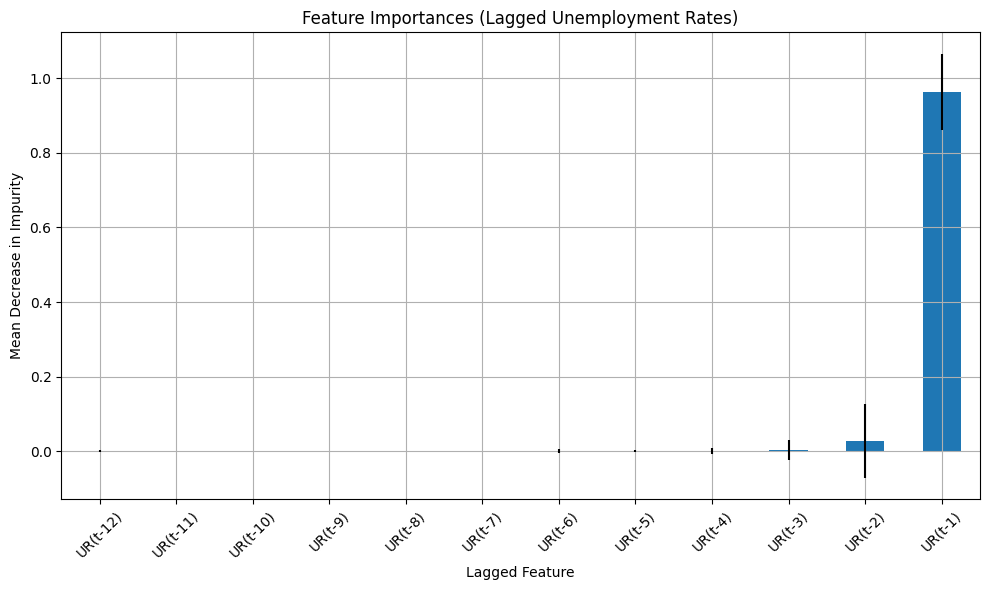

In [ ]:
importances = model_A.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_A.estimators_], axis=0)#measure importances

# FIX: Correct feature names for 12 lagged values
feature_names = [f'UR(t-{i})' for i in range(n_lags, 0, -1)]
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10, 6))
forest_importances.plot.bar(yerr=std)
plt.title("Feature Importances (Lagged Unemployment Rates)")
plt.xlabel("Lagged Feature")
plt.ylabel("Mean Decrease in Impurity")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


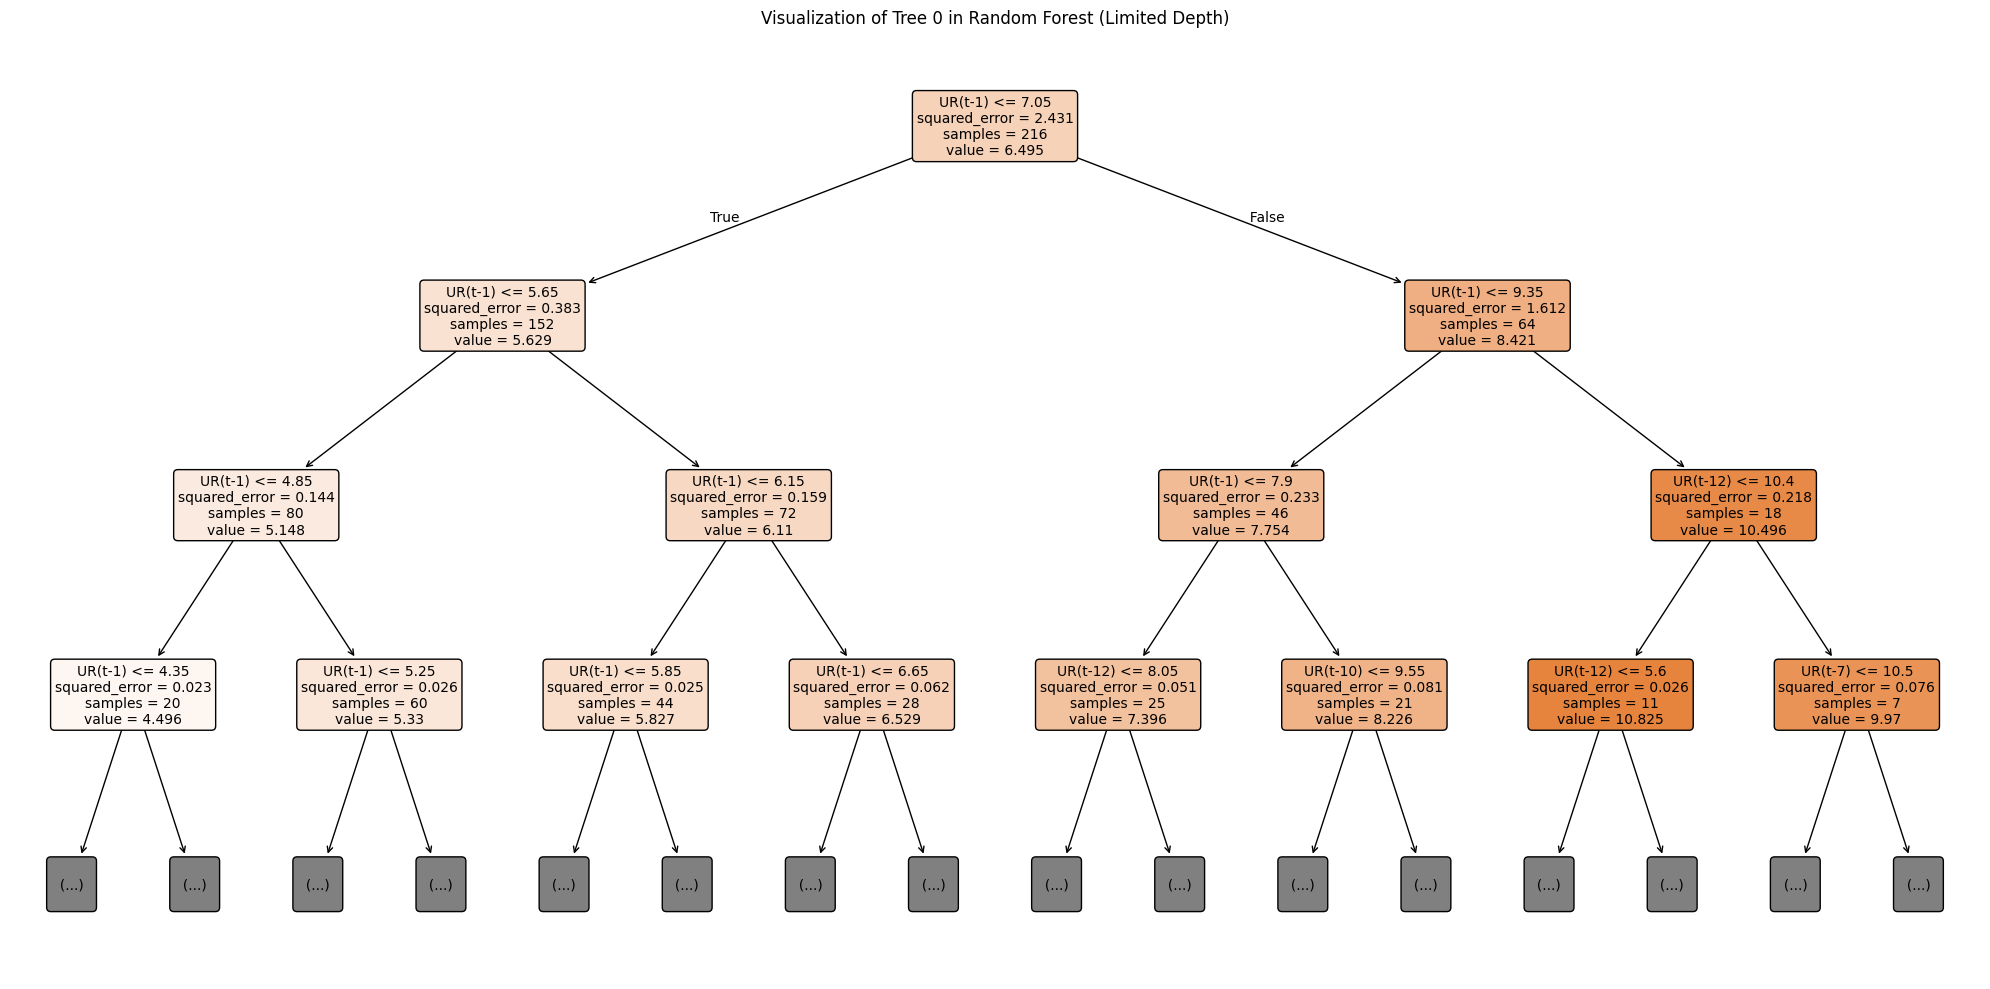

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# --- Select one estimator (first tree from the forest), which I select estimator 0 ---
estimator = model_A.estimators_[0]

# --- Plot the tree ---
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=[f'UR(t-{i})' for i in range(n_lags, 0, -1)],
    filled=True,
    rounded=True,
    max_depth=3,  # Plot only first 3 levels for readability
    fontsize=10
)
plt.title("Visualization of Tree 0 in Random Forest (Limited Depth)")
plt.tight_layout()
plt.show()
